# (1) Load Data
First, we load all the data we need into pandas dataframes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk.wsd import lesk
import nltk

In [2]:
from collections import namedtuple

Dataset = namedtuple('Dataset', 'name, train, test')
FeatureDataset = namedtuple('FeatureDataset', 'dataset_name, fc, train, test')
FeatureCategory = namedtuple('FeatureCategory', 'name, func')

In [3]:
MAIN_PATH_DATASET = "../cwishareddataset/traindevset/english/"
genres = ['Wikipedia', 'WikiNews', 'News']
datasets = ['Train', 'Dev']
columns = ['id', 'sentence', "start", "end", "target", 
           "nat", "non_nat", "nat_marked", "non_nat_marked", "binary", "prob"]


datasets = [Dataset('Wikipedia', 'Train', 'Dev'),
            Dataset('WikiNews', 'Train', 'Dev'),
            Dataset('News', 'Train', 'Dev')]

feature_categories = []

def load_df(path):
    df = pd.read_csv(path, header=None, sep = "\t")
    df.columns = columns
    return df

datasets = [Dataset(d.name, load_df(MAIN_PATH_DATASET + d.name + '_' + d.train + '.tsv'),
                            load_df(MAIN_PATH_DATASET + d.name + '_' + d.test + '.tsv'))
                            for d in datasets]

# (2) Preprocessing

# (2) Aggregation
Since many labels are multi-word expression, we first of all define some aggregation functions that aggregate feature values over multiple tokens. Implementing this seperately allows to easily exchange the used aggregation function and keeps the feature computation functions clean. These feature computation functions should only compute features for a single target word.

In [4]:
from nltk.tokenize import word_tokenize

def agg_feat_num_average(target, func_feature, *args):
    return np.mean([func_feature(token, *args) for token in word_tokenize(target)])

def agg_feat_num_median(target, func_feature, *args):
    return np.median([func_feature(token, *args) for token in word_tokenize(target)])

def agg_feat_num_max(target, func_feature, *args):
    return np.max([func_feature(token, *args) for token in word_tokenize(target)])

def agg_feat_num_min(target, func_feature, *args):
    return np.min([func_feature(token, *args) for token in word_tokenize(target)])

In [5]:
def concat_feature_datasets(*args):
    zipped = zip(*args)
    concat_features = []
    for dataset in zipped:
        df_train = None
        df_test = None
        fcs = []
        for tpl in dataset:
            if not fcs:
                df_train = tpl.train.copy()
                df_test = tpl.test.copy()
            else:
                df_train = pd.concat([df_train, tpl.train.copy()], axis = 1)
                df_test = pd.concat([df_test, tpl.test.copy()], axis = 1)
            fcs.append(tpl.fc)
        concat_features.append(FeatureDataset(tpl.dataset_name, fcs, 
                    df_train.loc[:,~df_train.columns.duplicated()], 
                    df_test.loc[:,~df_test.columns.duplicated()]))
    return concat_features

# (3) Features 

## (3.1) Orthographic features
Here we start computing simple features like the length of the target word.

In [6]:
from nltk.tokenize import word_tokenize
import string

def ratio_cap_letters(target):
    return np.sum([1 for letter in target if letter.isupper()]) / len(target)

def ratio_num_letters(target):
    return np.sum([1 for letter in target if letter.isdigit()]) / len(target)

def ratio_non_ascii_letters(target):
    ascii = set(string.printable)   
    return 1 - (np.sum([1 for letter in target if letter in ascii]) / len(target))

def features_orthographic(dataframe):
    df = dataframe.copy()
    df['length'] = df.target.apply(lambda target : agg_feat_num_average(target, len))
    df['target_num_words'] = df.target.apply(lambda target : len(word_tokenize(target)))
    # Relative positions of the target word based on character counting
    df['relative_position_left'] = df[['sentence', 'start']].apply(lambda vals : vals[1] / len(vals[0]), axis = 1)
    df['relative_position_centered'] = df[['sentence', 'start', 'end']].apply(lambda vals : 
                ((vals[1] + vals[2]) / 2) / len(vals[0]), axis = 1)
    df['relative_position_right'] = df[['sentence', 'end']].apply(lambda vals : vals[1] / len(vals[0]), axis = 1)
    df['ratio_cap_letters'] = df.target.apply(lambda target : agg_feat_num_average(target, ratio_cap_letters))
    df['all_caps'] = df.ratio_cap_letters == 1
    df['ratio_num_letters'] = df.target.apply(lambda target : agg_feat_num_average(target, ratio_num_letters))
    df['ratio_non_ascii_letters'] = df.target.apply(lambda target : agg_feat_num_average(target, ratio_non_ascii_letters))
    df['hyphenated'] = df.target.apply(lambda target : int('-' in target))
    return df

fc_orthographic = FeatureCategory('orthographic', features_orthographic)
feature_categories.append(fc_orthographic)

In [17]:
dataset_fc_orthographic = [FeatureDataset(ds.name, fc_orthographic, 
                        fc_orthographic.func(ds.train), fc_orthographic.func(ds.test)) for ds in datasets]

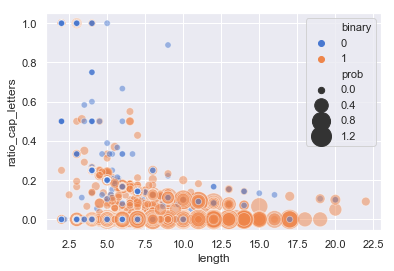

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

data = dataset_fc_orthographic[0].train

complexity_plot = sns.scatterplot(x="length", y="ratio_cap_letters", hue="binary", size='prob',
            sizes=(40, 400), alpha=.5, palette="muted",
            data=data)
plt.show(complexity_plot)

In [38]:
figure = complexity_plot.get_figure()
figure.savefig('../plots/features/length-to-ratio-num-letters.pdf')

## (3.2) Linguistic Features
Here we compute linguistic word features like the number of vowels the word has.

In [9]:
from nltk.corpus import cmudict
import numpy as np
import pronouncing as pnc
from wordmodel import Word
from nltk.stem.porter import *
from nltk.stem.wordnet import *
from nltk.tag.stanford import StanfordNERTagger
from nltk.parse.stanford import StanfordDependencyParser
from nltk.tokenize import word_tokenize
import os
from functools import lru_cache
from collections import Counter

java_path = "C:/Program Files (x86)/Java/jdk1.8.0_144/bin/java.exe"
os.environ['JAVAHOME'] = java_path
path_to_jar = 'resources/stanford-dependency-parser/stanford-parser.jar'
path_to_models_jar = 'resources/stanford-dependency-parser/stanford-parser-3.9.1-models.jar'

porterStemmer = PorterStemmer()
wordNetLemmatizer = WordNetLemmatizer()
nerTagger = StanfordNERTagger('resources/stanford-ner-tagger/classifiers/english.all.3class.distsim.crf.ser.gz',
               'resources/stanford-ner-tagger/stanford-ner.jar',
               encoding='utf-8')
dependencyParser = StanfordDependencyParser(path_to_jar=path_to_jar, path_to_models_jar=path_to_models_jar)

words_mrc_database = {}
with open("resources/mrc-database/mrc2.dct", encoding="utf8") as file:
    for index, line in enumerate(file):
        line = line.strip()
        word, phon, dphon, stress = line[51:].split('|')
        w = Word(
                wid = index,
                nlet = int(line[0:2]),
                nphon = int(line[2:4]),
                nsyl = int(line[4]),
                kf_freq = int(line[5:10]),
                kf_ncats = int(line[10:12]),
                kf_nsamp = int(line[12:15]),
                tl_freq = int(line[15:21]),
                brown_freq = int(line[21:25]),
                fam = int(line[25:28]),
                conc = int(line[28:31]),
                imag = int(line[31:34]),
                meanc = int(line[34:37]),
                meanp = int(line[37:40]),
                aoa = int(line[40:43]),
                tq2 = line[43],
                wtype = line[44],
                pdwtype = line[45],
                alphasyl = line[46],
                status = line[47],
                var = line[48],
                cap = line[49],
                irreg = line[50],
                word=word,
                phon=phon,
                dphon=dphon,
                stress=stress)
        words_mrc_database[w.word.strip().lower()] = w

def mrc_database(target, func):
    word = words_mrc_database.get(target.strip().lower())
    return func(word) if word else 0

d = cmudict.dict()

def num_syllables_rule_based(target):
    vowels = "aeiouy"
    numVowels = 0
    lastWasVowel = False
    for wc in target:
        foundVowel = False
        for v in vowels:
            if v == wc:
                if not lastWasVowel: numVowels+=1  
                foundVowel = lastWasVowel = True
                break
        if not foundVowel:  
            lastWasVowel = False
    if len(target) > 2 and target[-2:] == "es":
        numVowels-=1
    elif len(target) > 1 and target[-1:] == "e":
        numVowels-=1
    return numVowels

def num_syllables(target):
    if target in d:
        return np.mean([len(list(y for y in x if y[-1].isdigit())) for x in d[target.lower()]])
    else:
        return num_syllables_rule_based(target)

def num_vowels(target):
    return np.sum([target.lower().count(vowel) for vowel in 'aeiouy'])

def num_pronounciations(target):
    return len(pnc.phones_for_word(target))

def cognate_across_languages_sim(target, sim_func, agg_func, translations):
    targ = target.strip().lower()
    translated = translations.get(targ)
    if not translated:
        return 0
    trans_texts = set([trans_word.text for trans_word in translated])
    similarities = [sim_func(targ,trans_text) 
                    for trans_text in trans_texts]
    return agg_func(similarities)

def porter_stem_len(target):
    return len(str(porterStemmer.stem(target)))

def porter_stemmer_num_steps(target):
    stem = target.lower()
    applied_steps = 0
    if porterStemmer.mode == porterStemmer.NLTK_EXTENSIONS and target in porterStemmer.pool:
            return applied_steps
    if porterStemmer.mode != porterStemmer.ORIGINAL_ALGORITHM and len(target) <= 2:
            return applied_steps
    step_funcs = [porterStemmer._step1a, porterStemmer._step1b, porterStemmer._step1c,
                  porterStemmer._step2, porterStemmer._step3, porterStemmer._step3,
                  porterStemmer._step4, porterStemmer._step5a, porterStemmer._step5b]
    for step_func in step_funcs:
        stem_step = step_func(stem)
        if stem_step != stem:
            stem = stem_step
            applied_steps += 1
    return applied_steps

def is_named_entity(sentence, target):
    tokenized_sent = word_tokenize(sentence)
    tagged_sent = nerTagger.tag(tokenized_sent)
    for token, tag in tagged_sent:
        if token == target and tag != 'O':
            return 1
    return 0

def named_entity_type(sentence, target):
    tokenized_sent = word_tokenize(sentence)
    tagged_sent = nerTagger.tag(tokenized_sent)
    return [tag for token, tag in tagged_sent if token == target][0]

@lru_cache(maxsize=None)
def targets_with_index(start, end, context):
    curr_pos = 0
    targets = []
    for index, token in enumerate(word_tokenize(context), 1):
        targets.append((token, index, curr_pos, (curr_pos + len(token))))
        curr_pos += len(token) + 1
    return [(target[0], target[1]) for target in targets \
            if target[2] >= start and target[3] <= end]

@lru_cache(maxsize=None)
def dependency_parse(sentence):
    dependency_parser = dependencyParser.raw_parse(sentence)
    dependencies = []
    parsetree = list(dependency_parser)[0]
    for index, node in parsetree.nodes.items():
        for relation, dependant in parsetree.nodes[index]['deps'].items():
            triple = ((node['word'], index), relation, \
                      (parsetree.nodes[dependant[0]]['word'], dependant[0]))
            if relation != 'root': dependencies.append(triple)
    return dependencies

@lru_cache(maxsize=None)
def dependency_parse_with_root(sentence):
    dependency_parser = dependencyParser.raw_parse(sentence)
    dependencies = []
    parsetree = list(dependency_parser)[0]
    for index, node in parsetree.nodes.items():
        for relation, dependant in parsetree.nodes[index]['deps'].items():
            triple = ((node['word'], index), relation, \
                      (parsetree.nodes[dependant[0]]['word'], dependant[0]))
            dependencies.append(triple)
    return dependencies

def dep_dist_to_head(target, start, end, context):
    targets = targets_with_index(start, end, context)
    triples = dependency_parse(context)
    return np.nan_to_num(np.mean([np.abs(triple[0][1] - triple[2][1])-1 
                                for triple in triples if triple[2] in targets]))

def dep_dist_to_root(target, start, end, context):
    targets = targets_with_index(start, end, context)
    triples = dependency_parse_with_root(context)
    root_node = list(filter(lambda triple : triple[1] == 'root' , triples))[0]
    dist = np.nan_to_num(np.mean([np.abs(root_node[2][1] - triple[2][1])-1 
                                for triple in triples if triple[2] in targets]))
    return dist if dist != -1 else 0

def dep_relation_to_head(target, start, end, context):
    targets = targets_with_index(start, end, context)
    triples = dependency_parse_with_root(context)
    return [triple[1] for triple in triples if triple[2] in targets]

def dep_head_word_len(target, start, end, context):
    targets = targets_with_index(start, end, context)
    triples = dependency_parse(context)
    return np.nan_to_num(np.mean([len(triple[0][0]) 
        for triple in triples if triple[2] in targets]))

def dep_num_dependents(target, start, end, context):
    targets = targets_with_index(start, end, context)
    triples = dependency_parse_with_root(context)
    return len([triple[1] for triple in triples if triple[0] in targets])

def dep_max_num_dependents(context):
    triples = dependency_parse_with_root(context)
    return Counter([triple[0][0] for triple in triples]).most_common(1)[0][1]

In [10]:
targets_train = list(set([ngram for ds in datasets for mwe in ds.train['target'].tolist() for ngram in mwe.split()]))
targets_test = list(set([ngram for ds in datasets for mwe in ds.test['target'].tolist() for ngram in mwe.split()]))
targets = targets_train.copy()
targets.extend(targets_test)
print('Len ta_train : {}'.format(len(targets_train)))
print('Len ta_test : {}'.format(len(targets_test)))
print('Len targets : {}'.format(len(targets)))

Len ta_train : 7728
Len ta_test : 1893
Len targets : 9621


In [11]:
from googletrans import Translator
from collections import defaultdict
import pickle
with open('resources/translations/data.json', 'rb') as fp:
    data = pickle.load(fp)

if not data:
    translator = Translator()
    targets = [target.strip().lower() for target in targets]
    languages = ['fr', 'de', 'es']
    translations = defaultdict(list)
    for index, word in enumerate(targets):
        translator = Translator()
        for lang in languages:
            trans_word = translator.translate(word, dest=lang)
            translations[word].append(trans_word)
            print(str(index) + " " + word + " " + trans_word.text)
    with open('resources/translations/data.json', 'wb') as fp:
        pickle.dump(translations, fp, protocol=pickle.HIGHEST_PROTOCOL)
else:
    translations = data

In [12]:
from similarity.ngram import NGram
bigram_dist = NGram(2)
trigram_dist = NGram(3)

def features_linguistic(dataframe):
    df = dataframe.copy()
    df['mrc_nphon'] = df.target.apply(lambda target : agg_feat_num_average(target, mrc_database, lambda word : word.nphon))
    df['cal_ngram_2_sim_min'] = df.target.apply(lambda target : agg_feat_num_average(target, cognate_across_languages_sim, \
                                lambda source, dest : 1 - bigram_dist.distance(source, dest), np.min, translations))
    df['cal_ngram_2_sim_max'] = df.target.apply(lambda target : agg_feat_num_average(target, cognate_across_languages_sim, \
                                lambda source, dest : 1 - bigram_dist.distance(source, dest), np.max, translations))
    df['cal_ngram_2_sim_mean'] = df.target.apply(lambda target : agg_feat_num_average(target, cognate_across_languages_sim, \
                                lambda source, dest : 1 - bigram_dist.distance(source, dest), np.mean, translations))
    df['cal_ngram_3_sim_min'] = df.target.apply(lambda target : agg_feat_num_average(target, cognate_across_languages_sim, \
                                lambda source, dest : 1 - trigram_dist.distance(source, dest), np.min, translations))
    df['cal_ngram_3_sim_max'] = df.target.apply(lambda target : agg_feat_num_average(target, cognate_across_languages_sim, \
                                lambda source, dest : 1 - trigram_dist.distance(source, dest), np.max, translations))
    df['cal_ngram_3_sim_mean'] = df.target.apply(lambda target : agg_feat_num_average(target, cognate_across_languages_sim, \
                                lambda source, dest : 1 - trigram_dist.distance(source, dest), np.mean, translations))
    df['num_syllables'] = df.target.apply(lambda target : agg_feat_num_average(target, num_syllables))
    df['num_vowels'] = df.target.apply(lambda target : agg_feat_num_average(target, num_vowels))
    df['vowel_consonant_ratio'] = df.target.apply(lambda target : agg_feat_num_average(target, \
                                            lambda target : num_vowels(target) / (len(target) - num_vowels(target))))
    df['num_pronounciations'] = df.target.apply(lambda target : agg_feat_num_average(target, num_pronounciations))
    df['dep_dist_to_head'] = df[['target', 'start', 'end', 'sentence']].apply(lambda vals : 
                                                                            dep_dist_to_head(*vals), axis=1)
    df['dep_dist_to_root'] = df[['target', 'start', 'end', 'sentence']].apply(lambda vals : 
                                                                            dep_dist_to_root(*vals), axis=1)
    df['dep_dist_to_root_norm'] = df[['dep_dist_to_root', 'sentence']].apply(lambda vals : \
                                                        float(vals[0]) / (len(word_tokenize(vals[1]))-1), axis=1)
    df['dep_relation_to_head'] = df[['target', 'start', 'end', 'sentence']].apply(lambda vals : \
                                                                dep_relation_to_head(*vals), axis = 1)
    df['dep_num_dependents'] = df[['target', 'start', 'end', 'sentence']].apply(lambda vals : \
                                                                        dep_num_dependents(*vals), axis = 1)
    df['dep_max_num_dependents'] = df.sentence.apply(lambda sentence : dep_max_num_dependents(sentence))
    df['dep_num_dependents_norm'] = df.dep_num_dependents / df_small.dep_max_num_dependents
    df['dep_head_word_len'] = df[['target', 'start', 'end', 'sentence']].apply(lambda vals : \
                                                                        dep_head_word_len(*vals), axis = 1)
    # Porter stemmer stem length, number of applied steps,
    # difference of stem length to target and reduction ratio
    df['porter_stem_len'] = df.target.apply(lambda target : agg_feat_num_average(target, porter_stem_len))
    df['porter_stemmer_num_steps'] = df.target.apply(lambda target : agg_feat_num_average(target, porter_stemmer_num_steps))
    df['diff_len_stem_len'] = df.length - df.porter_stem_len
    df['reduction_stem_len'] = 1 - df.porter_stem_len / df.length
    return df
    
fc_linguistic = FeatureCategory('linguistic', features_linguistic)
feature_categories.append(fc_linguistic)

In [13]:
dataset_fc_linguistic = [FeatureDataset(ds.name, fc_linguistic, 
                        fc_linguistic.func(ds.train), fc_linguistic.func(ds.test)) for ds in datasets]

In [14]:
concat_features = concat_feature_datasets(dataset_fc_linguistic, dataset_fc_orthographic)

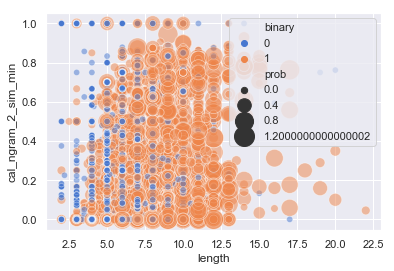

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

#Select wikipedia train set of concatenation
data = concat_features[0].train
#data = data.loc[data.cal_ngram_2_sim_min<0.3,]

complexity_plot = sns.scatterplot(x="length", y="cal_ngram_2_sim_min", hue="binary", size='prob',
            sizes=(40, 400), alpha=.5, palette="muted",
            data=data)
plt.show(complexity_plot)

In [41]:
figure = complexity_plot.get_figure()
figure.savefig('../plots/features/length-to-cal_ngram_2_sim_min.pdf')

# (3.3) Corpus-Based Features
Here we compute features which are based on larger corpora. In this category we distinguish e.g. between frequency counts and N-Gram Language Model probabilites.

### (1) Frequency

In [52]:
from nltk.stem.wordnet import *
from collections import defaultdict
from wordmodel import Word
import pandas as pd

words_mrc_database = {}
with open("resources/mrc-database/mrc2.dct", encoding="utf8") as file:
    for index, line in enumerate(file):
        line = line.strip()
        word, phon, dphon, stress = line[51:].split('|')
        w = Word(
                wid = index,
                nlet = int(line[0:2]),
                nphon = int(line[2:4]),
                nsyl = int(line[4]),
                kf_freq = int(line[5:10]),
                kf_ncats = int(line[10:12]),
                kf_nsamp = int(line[12:15]),
                tl_freq = int(line[15:21]),
                brown_freq = int(line[21:25]),
                fam = int(line[25:28]),
                conc = int(line[28:31]),
                imag = int(line[31:34]),
                meanc = int(line[34:37]),
                meanp = int(line[37:40]),
                aoa = int(line[40:43]),
                tq2 = line[43],
                wtype = line[44],
                pdwtype = line[45],
                alphasyl = line[46],
                status = line[47],
                var = line[48],
                cap = line[49],
                irreg = line[50],
                word=word,
                phon=phon,
                dphon=dphon,
                stress=stress)
        words_mrc_database[w.word.strip().lower()] = w

def mrc_database(target, func):
    word = words_mrc_database.get(target.strip().lower())
    return func(word) if word else 0

word_freq_wiki = {}
freq_sum_wiki = 0
with open("resources/word-freq-dumps/enwiki-20150602-words-frequency.txt", encoding="utf8") as file:
    for line in file:
        word, freq = line.partition(" ")[::2]
        word_freq_wiki[word.strip()] = int(freq)
        freq_sum_wiki+=int(freq)
        
word_freq_simple_wiki = {}
freq_sum_simple_wiki = 0
with open("resources/word-freq-dumps/simple_wiki_word_freqs.txt", encoding="ISO-8859-1") as file:
    for line in file:
        word, freq = line.split()
        word_freq_simple_wiki[word.strip()] = int(freq)
        freq_sum_simple_wiki+=int(freq)

word_freq_bnc = {}
with open("resources/word-freq-dumps/bnc_freq_all.al", encoding="utf8") as file:
    for line in file:
        freq, word, pos, num_files = line.split()
        word_freq_bnc[word.strip()] = (int(freq), pos, int(num_files))

word_freq_bnc_lemma = {}
with open("resources/word-freq-dumps/bnc_lemma.al", encoding="utf8") as file:
    for line in file:
        sort_order, frequency, word, word_class = line.split()
        word_freq_bnc_lemma[word.strip()] = (int(sort_order), word_class, int(frequency))

        
word_pknown_nobs_prev_freqZipf = {}
with open("resources/word-freq-dumps/word_prevelance.csv", encoding="utf8") as file:
    for line in file:
        word, p_known, nobs, prevelance, freqZipf = line.split(";")
        word_pknown_nobs_prev_freqZipf[word.strip()] = (float(p_known.replace(',','.')), 
                                                        float(nobs.replace(',','.')), 
                                                        float(prevelance.replace(',','.')), 
                                                        float(freqZipf.replace(',','.')))
        
subtlex_us = {}
with open("resources/dictionaries/SUBTLEXus.txt", encoding="utf8") as file:
    for line in file:
        word, freq, cd_count, freq_low, cd_low, subtl_wf, lg10_wf, Subtlcd, lg10_cd = line.split('\t')
        subtlex_us[word.strip().lower()] = (int(freq), int(cd_count))
        
subtlex_uk = pd.read_csv("resources/dictionaries/SUBTLEXuk.txt", sep = "\t")
subtlex_uk_dict = dict(zip(subtlex_uk['Spelling'], subtlex_uk['CD_count']))

def get_dict_count(target, freqs):
    return freqs.get(target.strip().lower(), 0)

def freqZipf(target):
    stats = word_pknown_nobs_prev_freqZipf.get(target)
    return stats[3] if stats else 3.5


N_WEIGHT = freq_sum_wiki / freq_sum_simple_wiki

def weighted_wiki_simple_wiki_ratio(target, weight):
    freq_wiki = word_freq_wiki.get(target.strip().lower(), 1)
    freq_simple_wiki = word_freq_simple_wiki.get(target.strip().lower(), 1)
    return -1 + (2 * (freq_wiki / ((freq_simple_wiki * weight) + freq_wiki)))

C:\Users\Studio\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (11,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [48]:
mwe_targets_train = list(set([mwe for ds in datasets for mwe in ds.train['target'].tolist()]))
mwe_targets_test = list(set([mwe for ds in datasets for mwe in ds.test['target'].tolist()]))
mwe_targets = mwe_targets_train.copy()
mwe_targets.extend(mwe_targets_test)
print('Len ta_train : {}'.format(len(mwe_targets_train)))
print('Len ta_test : {}'.format(len(mwe_targets_test)))
print('Len targets : {}'.format(len(mwe_targets)))

Len ta_train : 10716
Len ta_test : 2278
Len targets : 12994


In [55]:
import phrasefinder as pf

google_books_n_grams = {}
options = pf.SearchOptions()
options.topk = 10
n_grams = mwe_targets

with open('resources/word-freq-dumps/ngram_google.json', 'rb') as fp:
    google_books_n_grams = pickle.load(fp)

if not google_books_n_grams:
    for index, n_gram in enumerate(n_grams):
        try:
            print(index, n_gram)
            result = pf.search(pf.Corpus.AMERICAN_ENGLISH, n_gram, options)
            vals = [(phrase.match_count, phrase.volume_count, phrase.first_year, phrase.last_year)
                        for phrase in result.phrases]
            mean_vals = [np.sum(elem) / len(elem) for elem in zip(*vals)]
            google_books_n_grams[n_gram] = mean_vals
            if result.status != pf.Status.Ok:
                print('Request was not successful: {}'.format(result.status))
        except Exception as error:
            pass
    with open('resources/word-freq-dumps/ngram_google.json', 'wb') as fp:
        pickle.dump(google_books_n_grams, fp, protocol=pickle.HIGHEST_PROTOCOL)

FileNotFoundError: [Errno 2] No such file or directory: 'resources/word-freq-dumps/ngram_google.json'

### (2) Language Model
Here we load the different Kneser-Ney n-gram models we trained previously.

In [62]:
import pickle

with open('resources/language-models/ngram_char_1.json', 'rb') as fp:
    ngram_char_1 = pickle.load(fp)
    
with open('resources/language-models/ngram_word_1.json', 'rb') as fp:
    ngram_word_1 = pickle.load(fp)

with open('resources/language-models/ngram_char_2.json', 'rb') as fp:
    ngram_char_2 = pickle.load(fp)
    
with open('resources/language-models/ngram_word_2.json', 'rb') as fp:
    ngram_word_2 = pickle.load(fp)
    
with open('resources/language-models/ngram_char_3.json', 'rb') as fp:
    ngram_char_3 = pickle.load(fp)
    
def kneser_ney_word_uni_gram(target):
    return ngram_word_1.cond_prob(target)

def kneser_ney_word_bi_gram(target):
    words = target.split()
    if len(words) <= 1:
        return ngram_word_2.cond_prob(target)
    return np.mean([ngram_word_2.cond_prob(words[index+1], (word,)) 
                for index, word in enumerate(words) 
                if index <= len(words)-2])
    
def kneser_ney_char_uni_gram_avg(target):
    return np.mean([ngram_char_1.cond_prob(character) 
            for character in target])

def kneser_ney_char_bi_gram_avg(target):
    return np.mean([ngram_char_2.cond_prob(target[index+1], (character,)) 
            for index, character in enumerate(target) if index <= len(target)-2])

def kneser_ney_char_tri_gram_avg(target):
    return np.mean([ngram_char_3.cond_prob(target[index+2], (character, target[index+1])) 
            for index, character in enumerate(target) if index <= len(target)-3])

In [63]:
from nltk.stem.wordnet import *
wordNetLemmatizer = WordNetLemmatizer()

def features_corpus_based(dataframe):
    df = dataframe.copy()
    df['mrc_kf_freq'] = df.target.apply(lambda target : agg_feat_num_average(target, mrc_database, \
                                                                    lambda word : word.kf_freq))
    df['mrc_kf_ncats'] = df.target.apply(lambda target : agg_feat_num_average(target, mrc_database, \
                                                                    lambda word : word.kf_ncats))
    df['mrc_tl_freq'] = df.target.apply(lambda target : agg_feat_num_average(target, mrc_database, \
                                                                    lambda word : word.tl_freq))
    df['mrc_brown_freq'] = df.target.apply(lambda target : agg_feat_num_average(target, mrc_database, \
                                                                    lambda word : word.brown_freq))
    df['freq_wiki'] = df.target.apply(lambda target : agg_feat_num_average(target, get_dict_count, word_freq_wiki))
    df['log_freq_wiki'] = df.freq_wiki.apply(lambda freq : np.nan_to_num(np.log(freq)))
    df['freq_simple_wiki'] = df.target.apply(lambda target : agg_feat_num_average(target, get_dict_count, word_freq_simple_wiki))
    df['log_freq_simple_wiki'] = df.freq_simple_wiki.apply(lambda freq : np.nan_to_num(np.log(freq)))
    df['freq_bnc'] = df.target.apply(lambda target : agg_feat_num_average(target, \
                                    lambda target : word_freq_bnc.get(target)[0] if word_freq_bnc.get(target) else 0))
    df['log_freq_bnc'] = df.freq_bnc.apply(lambda freq : np.nan_to_num(np.log(freq)))
    df['freq_bnc_lemma'] = df.target.apply(lambda target : agg_feat_num_average(target, \
                    lambda target : word_freq_bnc_lemma.get(wordNetLemmatizer.lemmatize(target))[2] \
                                            if word_freq_bnc_lemma.get(wordNetLemmatizer.lemmatize(target)) else 0))
    df['log_freq_bnc_lemma'] = df.freq_bnc_lemma.apply(lambda freq : np.nan_to_num(np.log(freq)))
    df['freqZipf'] = df.target.apply(lambda target : agg_feat_num_average(target, freqZipf))
    df['google_books_n_gram_freq'] = df.target.apply(lambda target : google_books_n_grams.get(target)[0] \
                                                     if google_books_n_grams.get(target) else 0)
    df['log_google_books_n_gram_freq'] = df.google_books_n_gram_freq.apply(lambda freq : np.nan_to_num(np.log(freq)))
    df['google_books_n_gram_doc_freq'] = df.target.apply(lambda target : google_books_n_grams.get(target)[1] \
                                                        if google_books_n_grams.get(target)  else 0)
    df['log_google_books_n_gram_doc_freq'] = df.google_books_n_gram_doc_freq.apply(lambda freq : np.nan_to_num(np.log(freq)))
    df['google_books_n_gram_first_year'] = df.target.apply(lambda target : google_books_n_grams.get(target)[2] \
                                                          if google_books_n_grams.get(target)  else 0)
    df['google_books_n_gram_last_year'] = df.target.apply(lambda target : google_books_n_grams.get(target)[3] \
                                                         if google_books_n_grams.get(target)  else 0)
    df['subtlex_cd_us'] = df.target.apply(lambda target : agg_feat_num_average(target, \
                    lambda target : subtlex_us[target.strip().lower()][1] if subtlex_us.get(target.strip().lower()) else 0))
    df['subtlex_cd_uk'] = df.target.apply(lambda target : agg_feat_num_average(target, \
                                    lambda target : subtlex_uk_dict.get(target, 0)))
    df['kneser_ney_word_uni_gram'] = df.target.apply(lambda target : agg_feat_num_average(target, \
                                                    kneser_ney_word_uni_gram))
    df['kneser_ney_word_bi_gram'] = df.target.apply(lambda target :  kneser_ney_word_bi_gram(target))
    df['kneser_ney_char_uni_gram_avg'] = df.target.apply(lambda target : agg_feat_num_average(target, \
                                                    kneser_ney_char_uni_gram_avg))
    df['kneser_ney_char_bi_gram_avg'] = df.target.apply(lambda target : agg_feat_num_average(target, \
                                                    kneser_ney_char_bi_gram_avg))
    df['kneser_ney_char_tri_gram_avg'] = df.target.apply(lambda target : agg_feat_num_average(target, \
                                                    kneser_ney_char_tri_gram_avg))
    df['weighted_wiki_simple_wiki_ratio'] = df.target.apply(lambda target : agg_feat_num_average(target, \
                                                                weighted_wiki_simple_wiki_ratio, N_WEIGHT))
    return df

fc_corpus_based = FeatureCategory('corpus-based', features_corpus_based)
feature_categories.append(fc_corpus_based)

In [64]:
dataset_fc_corpus_based = [FeatureDataset(ds.name, fc_corpus_based, 
                fc_corpus_based.func(ds.train), fc_corpus_based.func(ds.test)) for ds in datasets]

C:\Users\Studio\Anaconda3\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [68]:
train = dataset_fc_corpus_based[0].train
train.loc[(train.weighted_wiki_simple_wiki_ratio>-0.1) & (train.weighted_wiki_simple_wiki_ratio<0.1),]

,id,sentence,start,end,target,nat,non_nat,nat_marked,non_nat_marked,binary,...,google_books_n_gram_first_year,google_books_n_gram_last_year,subtlex_cd_us,subtlex_cd_uk,kneser_ney_word_uni_gram,kneser_ney_word_bi_gram,kneser_ney_char_uni_gram_avg,kneser_ney_char_bi_gram_avg,kneser_ney_char_tri_gram_avg,weighted_wiki_simple_wiki_ratio
2,3XU9MCX6VODXPI3L8I02CM94TFB2R7,"Normally , the land will be passed down to fut...",15,19,land,10,10,0,0,0,...,0,0,2074.00,12218.0,9.271342e-05,1.056890e-04,0.054796,0.145468,0.303273,-0.033086
5,3XU9MCX6VODXPI3L8I02CM94TFB2R7,"Normally , the land will be passed down to fut...",50,61,generations,10,10,3,2,1,...,0,0,263.00,3264.0,1.617540e-05,1.856698e-05,0.072094,0.112905,0.237674,0.034149
9,3XU9MCX6VODXPI3L8I02CM94TFB2R7,"Normally , the land will be passed down to fut...",104,142,traditional connection to that country,10,10,0,0,0,...,0,0,4280.60,24521.6,6.277353e-03,2.890158e-02,0.064920,0.124052,NaN,0.080333
16,3XU9MCX6VODXPI3L8I02CM94TFB2R7,The passing of Aboriginal land rights legislat...,26,30,land,10,10,0,0,0,...,0,0,2074.00,12218.0,9.271342e-05,1.056890e-04,0.054796,0.145468,0.303273,-0.033086
18,3XU9MCX6VODXPI3L8I02CM94TFB2R7,The passing of Aboriginal land rights legislat...,31,37,rights,10,10,0,0,0,...,0,0,1021.00,4974.0,1.610641e-04,1.048558e-04,0.054967,0.064518,0.285606,-0.006761
22,3XU9MCX6VODXPI3L8I02CM94TFB2R7,The passing of Aboriginal land rights legislat...,80,86,number,10,10,0,0,0,...,0,0,4542.00,24656.0,3.608571e-04,1.243750e-04,0.049739,0.103624,0.276039,0.014191
38,3XU9MCX6VODXPI3L8I02CM94TFB2R7,The passing of Aboriginal land rights legislat...,254,280,Aboriginal Lands Trust Act,10,10,0,0,0,...,0,0,1897.25,0.0,2.356166e-05,5.246830e-05,0.044895,0.099816,0.199045,0.026723
41,3XU9MCX6VODXPI3L8I02CM94TFB2R7,The passing of Aboriginal land rights legislat...,265,270,Lands,10,10,0,0,0,...,0,0,252.00,0.0,8.739317e-07,3.808611e-06,0.048656,0.147236,0.209184,0.065057
45,3XU9MCX6VODXPI3L8I02CM94TFB2R7,The passing of Aboriginal land rights legislat...,317,322,South,10,10,0,0,0,...,0,0,1693.00,0.0,2.891794e-04,1.590095e-04,0.043900,0.150528,0.213710,-0.041666
46,3XU9MCX6VODXPI3L8I02CM94TFB2R7,The passing of Aboriginal land rights legislat...,323,333,Australian,10,10,0,0,0,...,0,0,82.00,0.0,6.000997e-05,5.891445e-05,0.055685,0.103880,0.191720,0.060145


In [72]:
concat_features = concat_feature_datasets(dataset_fc_corpus_based, dataset_fc_orthographic)

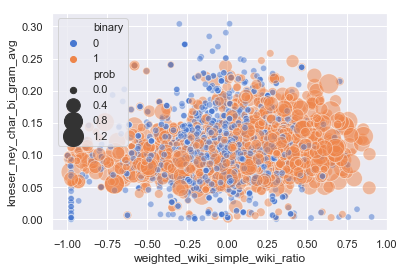

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

#Select wikipedia train set of concatenation
data = concat_features[0].train
#data = data.loc[data.cal_ngram_2_sim_min<0.3,]
#data['kneser20'] = data.kneser_ney_word_uni_gram * 10000
#data = data.loc[data.kneser20<10,]
complexity_plot_1 = sns.scatterplot(x="weighted_wiki_simple_wiki_ratio", y="kneser_ney_char_bi_gram_avg", hue="binary", size='prob',
            sizes=(40, 400), alpha=.5, palette="muted",
            data=data)
plt.show(complexity_plot_1)

In [93]:
figure = complexity_plot_1.get_figure()
figure.savefig('../plots/features/ratio-freqs-to-bigram.pdf')

C:\Users\Studio\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


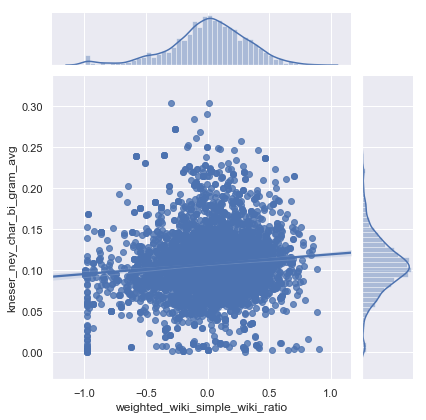

In [94]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

#Select wikipedia train set of concatenation
data = concat_features[0].train
#data = data.loc[data.cal_ngram_2_sim_min<0.3,]

complexity_plot = sns.jointplot(x="weighted_wiki_simple_wiki_ratio", y="kneser_ney_char_bi_gram_avg", data=data, kind="reg")
plt.show(complexity_plot)

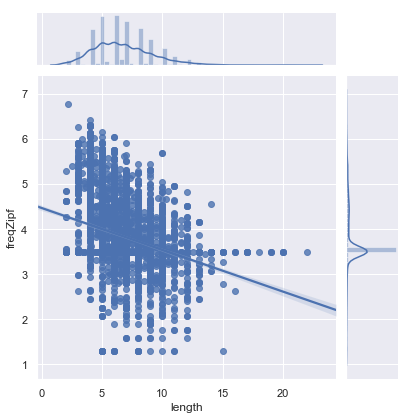

In [175]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

#Select wikipedia train set of concatenation
data = concat_features[0].train
#data = data.loc[data.cal_ngram_2_sim_min<0.3,]

complexity_plot = sns.jointplot(x="length", y="freqZipf", data=data, kind="reg")
plt.show(complexity_plot)

# (3.4) Psycholinguistic Features based on MRC Database


In [22]:
from wordmodel import Word

words_mrc_database = {}
with open("resources/mrc-database/mrc2.dct", encoding="utf8") as file:
    for index, line in enumerate(file):
        line = line.strip()
        word, phon, dphon, stress = line[51:].split('|')
        w = Word(
                wid = index,
                nlet = int(line[0:2]),
                nphon = int(line[2:4]),
                nsyl = int(line[4]),
                kf_freq = int(line[5:10]),
                kf_ncats = int(line[10:12]),
                kf_nsamp = int(line[12:15]),
                tl_freq = int(line[15:21]),
                brown_freq = int(line[21:25]),
                fam = int(line[25:28]),
                conc = int(line[28:31]),
                imag = int(line[31:34]),
                meanc = int(line[34:37]),
                meanp = int(line[37:40]),
                aoa = int(line[40:43]),
                tq2 = line[43],
                wtype = line[44],
                pdwtype = line[45],
                alphasyl = line[46],
                status = line[47],
                var = line[48],
                cap = line[49],
                irreg = line[50],
                word=word,
                phon=phon,
                dphon=dphon,
                stress=stress)
        words_mrc_database[w.word.strip().lower()] = w

def mrc_database(target, func, missing_val):
    word = words_mrc_database.get(target.strip().lower())
    return func(word) if word else missing_val

word_concreteness = {}
with open("resources/word-freq-dumps/concreteness_brysbaert_et_al.txt", encoding="utf8") as file:
    for line in file:
        word, bigram, conc_m, conc_sd, \
        unknown, total, percent_known, \
        subtlex, dom_pos = line.split('\t')
        word_concreteness[word.strip()] = float(conc_m)
        
word_age_of_aquisition = {}
with open("resources/word-freq-dumps/AoA_ratings_Kuperman_et_al_BRM.csv", encoding="utf8") as file:
    for line in file:
        word, occur_total, occur_num, freq_pm, rating_Mean, rating_SD, dunno = line.split()
        word_age_of_aquisition[word.strip()] = float(rating_Mean.replace(',', '.')) if rating_Mean != 'NA' else 0

word_pknown_nobs_prev_freqZipf = {}
with open("resources/word-freq-dumps/word_prevelance.csv", encoding="utf8") as file:
    for line in file:
        word, p_known, nobs, prevelance, freqZipf = line.split(";")
        word_pknown_nobs_prev_freqZipf[word.strip()] = (float(p_known.replace(',','.')), 
                                                        float(nobs.replace(',','.')), 
                                                        float(prevelance.replace(',','.')), 
                                                        float(freqZipf.replace(',','.')))

def perc_known(target, missing_value):
    stats = word_pknown_nobs_prev_freqZipf.get(target)
    return stats[0] if stats else missing_value

def nobs(target):
    stats = word_pknown_nobs_prev_freqZipf.get(target)
    return stats[1] if stats else 0

def prevelance(target):
    stats = word_pknown_nobs_prev_freqZipf.get(target)
    return stats[2] if stats else 0

In [23]:
def features_psycholingusitic(dataframe):
    df = dataframe.copy()
    df['mrc_fam'] = df.target.apply(lambda target : agg_feat_num_average(target, mrc_database, lambda word : word.fam, 400))
    df['mrc_conc'] = df.target.apply(lambda target : agg_feat_num_average(target, mrc_database, lambda word : word.conc, 400))
    df['mrc_imag'] = df.target.apply(lambda target : agg_feat_num_average(target, mrc_database, lambda word : word.imag, 400))
    df['mrc_meanc'] = df.target.apply(lambda target : agg_feat_num_average(target, mrc_database, lambda word : word.meanc, 400))
    df['mrc_meanp'] = df.target.apply(lambda target : agg_feat_num_average(target, mrc_database, lambda word : word.meanp, 400))
    df['mrc_aoa'] = df.target.apply(lambda target : agg_feat_num_average(target, mrc_database, lambda word : word.aoa, 3.5))
    df['perc_known'] = df.target.apply(lambda target : agg_feat_num_average(target, perc_known, 0.5))
    df['nobs'] = df.target.apply(lambda target : agg_feat_num_average(target, nobs))
    df['prevelance'] = df.target.apply(lambda target : agg_feat_num_average(target, prevelance))
    df['concreteness'] = df.target.apply(lambda target : agg_feat_num_average(target, \
                                                lambda target : word_concreteness.get(target, 2.5)))
    df['age_of_aquisition'] = df.target.apply(lambda target : agg_feat_num_max(target, \
                                                    lambda target : word_age_of_aquisition.get(target, 8.5)))
    return df

fc_psycholinguistic = FeatureCategory('corpus-based', features_psycholingusitic)
feature_categories.append(fc_psycholinguistic)

In [24]:
dataset_fc_psycholinguistic = [FeatureDataset(ds.name, fc_psycholinguistic, 
                fc_psycholinguistic.func(ds.train), fc_psycholinguistic.func(ds.test)) for ds in datasets]

In [30]:
concat_features = concat_feature_datasets(dataset_fc_psycholinguistic, dataset_fc_orthographic)

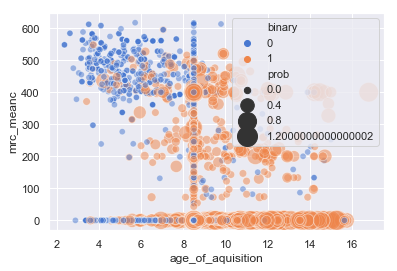

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

#Select wikipedia train set of concatenation
data = concat_features[0].train
#data = data.loc[data.cal_ngram_2_sim_min<0.3,]

complexity_plot = sns.scatterplot(x="age_of_aquisition", y="mrc_meanc", hue="binary", size='prob',
            sizes=(40, 400), alpha=.5, palette="muted",
            data=data)
plt.show(complexity_plot)

In [37]:
figure = complexity_plot.get_figure()
figure.savefig('../plots/features/aoa-mrc_meanc.pdf')

# (3.5) Semantic Features
Here we implement all the relevant features based on WordNet and SentiWordNet. For example, the number of synsets the target word is contained in or the average length of the lemmas of all the synsets the target word is contained in. Note that all features that are computed in the following exploit neither the POS-Tag of the target word nor Word Sense Disambiguation by e.g. UKB-Algorithm.

In [112]:
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk.wsd import lesk
from nltk.stem.wordnet import *

wordNetLemmatizer = WordNetLemmatizer()

def wn_synset_freq(target):
    return len(wn.synsets(target))

def wn_synset_avg_lemma_freq(target):
    return np.nan_to_num(np.mean([len(synset.lemmas()) 
            for synset in wn.synsets(target)]))

def wn_synset_avg_lemma_len(target):
    return np.nan_to_num(np.nanmean([len(lemma.name()) 
            for synset in wn.synsets(target) 
            for lemma in synset.lemmas()]))

def wn_synset_avg_hypernyms(target):
    return np.nan_to_num(np.nanmean([len(synset.hypernyms()) 
            for synset in wn.synsets(target)]))

def wn_synset_avg_hyponyms(target):
    return np.nan_to_num(np.mean([len(synset.hyponyms()) 
            for synset in wn.synsets(target)]))

def wn_synset_sum_hypernyms(target):
    return np.sum(([len(synset.hypernyms()) 
            for synset in wn.synsets(target)]))

def wn_synset_avg_definition_len(target):
    return np.nan_to_num(np.mean([len(str(synset.definition())) 
            for synset in wn.synsets(target)]))

def wn_synset_avg_hyptree_depth(target):
    return np.nan_to_num(np.mean([synset.max_depth() 
            for synset in wn.synsets(target)]))

def wn_synset_num_distinct_pos(target):
    return len(set([synset.pos() for synset in wn.synsets(target)]))

def wn_synset_avg_num_relations(target):
    return np.nan_to_num(np.mean([np.sum([len(synset.hypernyms()), len(synset.hyponyms()), 
             len(synset.instance_hypernyms()), len(synset.instance_hyponyms()),
             len(synset.member_holonyms()), len(synset.substance_holonyms()),
             len(synset.part_holonyms()), len(synset.member_meronyms()),
             len(synset.substance_meronyms()), len(synset.part_meronyms())]) 
             for synset in wn.synsets(target)]))

def wn_synset_avg_freq_pos(target, pos):
    return len(wn.synsets(target, pos = pos))

def wn_synset_sense_entropy_uniform(target):
    num_senses = len(wn.synsets(target))
    return -np.sum([((1 / num_senses) * np.log2(1 / num_senses)) 
                     for index in range(0, num_senses)])

def wn_synset_sense_entropy_pos_uniform(target):
    num_senses = len(wn.synsets(target))
    pos_distribution = [len(wn.synsets(target, pos = wn.NOUN)),
                        len(wn.synsets(target, pos = wn.VERB)),
                        len(wn.synsets(target, pos = wn.ADJ)),
                        len(wn.synsets(target, pos = wn.ADV))]
    return -np.sum([(np.nan_to_num((count / num_senses) * np.log2(count / num_senses))) 
            for count in pos_distribution]) if num_senses != 0 else 0

def wn_synsets_sense_entropy_pos_central(target, pos):
    num_senses_pos = len(wn.synsets(target, pos = pos))
    return -np.sum([((1 / num_senses_pos) * np.log2(1 / num_senses_pos))
                     for index in range(0, num_senses_pos)])

def wn_synsets_avg_lemma_freq(target, freqs_func, freqs):
    synsets = wn.synsets(target)
    if not synsets:
        return 0
    return np.mean([np.nan_to_num(freqs_func(lemma.name(), freqs)) for synset in synsets
                    for lemma in synset.lemmas()])

def penn_to_wn(tag):
    if not tag:
        return None
    if tag.startswith('N'):
        return 'n'
    if tag.startswith('V'):
        return 'v'
    if tag.startswith('J'):
        return 'a'
    if tag.startswith('R'):
        return 'r'
    return None

def wn_synsets_freq_ratio_to_max_agg_min(target, freqs_func, freqs):
    lemmas = [lemma.name().split('_') for synset in wn.synsets(target) 
                  for lemma in synset.lemmas()]
    if not lemmas:
        return 1
    freqis = [np.min([freqs_func(lemma, freqs) for lemma in lemmata]) 
              for lemmata in lemmas]
    target_freq = freqs_func(target, freqs)
    if target_freq not in freqis: freqis.append(target_freq)
    max_freq = np.max(freqis)
    return target_freq / max_freq

def wn_synsets_freq_ratio_to_max_agg_mean(target, freqs_func, freqs):
    lemmas = [lemma.name().split('_') for synset in wn.synsets(target) 
                  for lemma in synset.lemmas()]
    if not lemmas:
        return 1
    freqis = [np.mean([freqs_func(lemma, freqs) for lemma in lemmata]) 
              for lemmata in lemmas]
    target_freq = freqs_func(target, freqs)
    if target_freq not in freqis: freqis.append(target_freq)
    max_freq = np.max(freqis)
    return target_freq / max_freq

def wn_synsets_freq_ratio_to_max_agg_median(target, freqs_func, freqs):
    lemmas = [lemma.name().split('_') for synset in wn.synsets(target) 
                  for lemma in synset.lemmas()]
    if not lemmas:
        return 1
    freqis = [np.median([freqs_func(lemma, freqs) for lemma in lemmata]) 
              for lemmata in lemmas]
    target_freq = freqs_func(target, freqs)
    if target_freq not in freqis: freqis.append(target_freq)
    max_freq = np.max(freqis)
    return target_freq / max_freq
    
def swn_avg_objective_score(target):
    return np.nan_to_num(np.mean([senti_synset.obj_score() 
                for senti_synset in swn.senti_synsets(target)]))

def pos_tag(sentence, target):
    tokens = nltk.word_tokenize(sentence)
    wordPOSPairs = [token for token in nltk.pos_tag(tokens) if token[0] == target]
    return wordPOSPairs[0][1] if len(wordPOSPairs) > 0 else None

# TODO consider using stanford lemmatizer and compute word similarity metric
# to orignal target
def wordnet_lemma_len(target):
    return len(wordNetLemmatizer.lemmatize(target))

def wn_synset_lesk_wsd_ratio_hi_freq(target, sentence, pos, freqs_func, freqs):
    wsd_synset = lesk(sentence.split(), target, pos)
    if not wsd_synset:
        return 0
    lemmas = [lemma.name().split('_') for lemma in wsd_synset.lemmas()]
    if not lemmas:
        return 0
    freqis = [np.min([freqs_func(lemma, freqs) for lemma in lemmata])
              for lemmata in lemmas]
    target_freq = freqs_func(target, freqs)
    return np.sum([1 for freq in freqis if freq > target_freq]) / len(freqis)

def wn_synset_lesk_wsd_ratio_hi_freq_sum(target, sentence, pos, freqs_func, freqs):
    wsd_synset = lesk(sentence.split(), target, pos)
    if not wsd_synset:
        return 0
    lemmas = [lemma.name().split('_') for lemma in wsd_synset.lemmas()]
    if not lemmas:
        return 0
    freqis = [np.min([freqs_func(lemma, freqs) for lemma in lemmata])
              for lemmata in lemmas]
    target_freq = freqs_func(target, freqs)
    return np.sum([freq for freq in freqis if freq > target_freq]) / np.sum(freqis)

def wn_synset_lesk_wsd_ratio_hi_nopos_freq(target, sentence, freqs_func, freqs):
    wsd_synset = lesk(sentence.split(), target)
    if not wsd_synset:
        return 0
    lemmas = [lemma.name().split('_') for lemma in wsd_synset.lemmas()]
    if not lemmas:
        return 0
    freqis = [np.min([freqs_func(lemma, freqs) for lemma in lemmata])
              for lemmata in lemmas]
    target_freq = freqs_func(target, freqs)
    return np.sum([1 for freq in freqis if freq > target_freq]) / len(freqis)

def wn_synset_lesk_wsd_ratio_low_freq(target, sentence, pos, freqs_func, freqs):
    wsd_synset = lesk(sentence.split(), target, pos)
    if not wsd_synset:
        return 0
    lemmas = [lemma.name().split('_') for lemma in wsd_synset.lemmas()]
    if not lemmas:
        return 0
    freqis = [np.min([freqs_func(lemma, freqs) for lemma in lemmata])
              for lemmata in lemmas]
    target_freq = freqs_func(target, freqs)
    return np.sum([1 for freq in freqis if freq < target_freq]) / len(freqis)

def wn_synset_lesk_wsd_ratio_low_freq_sum(target, sentence, pos, freqs_func, freqs):
    wsd_synset = lesk(sentence.split(), target, pos)
    if not wsd_synset:
        return 0
    lemmas = [lemma.name().split('_') for lemma in wsd_synset.lemmas()]
    if not lemmas:
        return 0
    freqis = [np.min([freqs_func(lemma, freqs) for lemma in lemmata])
              for lemmata in lemmas]
    target_freq = freqs_func(target, freqs)
    return np.sum([freq for freq in freqis if freq < target_freq]) / np.sum(freqis)

def wn_synset_lesk_wsd_ratio_low_nopos_freq(target, sentence, freqs_func, freqs):
    wsd_synset = lesk(sentence.split(), target)
    if not wsd_synset:
        return 0
    lemmas = [lemma.name().split('_') for lemma in wsd_synset.lemmas()]
    if not lemmas:
        return 0
    freqis = [np.min([freqs_func(lemma, freqs) for lemma in lemmata])
              for lemmata in lemmas]
    target_freq = freqs_func(target, freqs)
    return np.sum([1 for freq in freqis if freq < target_freq]) / len(freqis)

def wn_synset_lesk_wsd_ratio_to_freq_sum(target, sentence, pos, freqs_func, freqs):
    wsd_synset = lesk(sentence.split(), target, pos)
    if not wsd_synset:
        return 0
    lemmas = [lemma.name().split('_') for lemma in wsd_synset.lemmas()]
    if not lemmas:
        return 0
    freqis = [np.min([freqs_func(lemma, freqs) for lemma in lemmata])
              for lemmata in lemmas]
    target_freq = freqs_func(target, freqs)
    return target_freq / np.sum(freqis)

#TODO implement with other wsd algorithm and lemma count
#Implement wsd algorithm based on word embeddings and also use pywsd
def wn_synset_lesk_wsd__norm_sense_rank(target, sentence, pos, freqs_func, freqs, wsd_func):
    wsd_synset = wsd_func(sentence.split(), target, pos)
    senses = wn.synsets(target)
    if not wsd_synset:
        return 0
    wsd_synset = lesk(sentence.split(), target, pos)
    sense_freqs = sorted([(sense, np.sum([lemma.count() for lemma in sense.lemmas()])) 
                   for sense in senses], key = lambda tpl : tpl[1], reverse=True)
    sense_index = [sense for sense, cnt in sense_freqs].index(wsd_synset)
    return sense_index / len(senses)

brown_cluster_word2cluster = {}
brown_cluster_cluster2words = defaultdict(list)
with open("resources/brown-clustering/paths/rcv1.clean-c6000-p1.paths", encoding="utf8") as file:
    for line in file:
        binary_cluster, word, _ = line.split()
        brown_cluster_word2cluster[word] = binary_cluster
        brown_cluster_cluster2words[binary_cluster].append(word)

def brown_clustering_cluster_size(target):
    cluster = brown_cluster_word2cluster.get(target)
    return len(brown_cluster_cluster2words[cluster]) if cluster else 0

def brown_clustering_cluster_depth_simple(target):
    cluster = brown_cluster_word2cluster.get(target)
    return int(cluster, 2) if cluster else 0

def brown_clustering_cluster_depth_bit(target):
    cluster = brown_cluster_word2cluster.get(target)
    if not cluster:
        return 0
    return np.sum([1 for bit in cluster if bit == '1'])

def brown_clustering_cluster_size_all(target):
    cluster = brown_cluster_word2cluster.get(target)
    if not cluster:
        return 0
    upper_clusters = [cluster[0:(len(cluster) - index)] + '0' * index \
         for index, bit in enumerate(reversed(cluster)) if bit == '1']
    cluster_counts = [len(brown_cluster_cluster2words.get(clu, [])) \
                         for clu in upper_clusters]
    return np.sum(cluster_counts)

In [113]:
from nltk.wsd import lesk
from pywsd.lesk import adapted_lesk

def features_semantic(dataframe):
    df = dataframe.copy()
    df['wn_synset_freq'] = df.target.apply(lambda target : agg_feat_num_average(target, wn_synset_freq))
    df['wn_synset_avg_lemma_freq'] = df.target.apply(lambda target : agg_feat_num_average(target, wn_synset_avg_lemma_freq))
    df['wn_synset_avg_lemma_len'] = df.target.apply(lambda target : agg_feat_num_average(target, wn_synset_avg_lemma_len))
    
    df['length'] = df.target.apply(lambda target : agg_feat_num_average(target, len))
    df['wn_synset_diff_len_avg_lemma_len'] = df.wn_synset_avg_lemma_len - df.length
    df['wn_synset_avg_hypernyms'] = df.target.apply(lambda target : agg_feat_num_average(target, wn_synset_avg_hypernyms))
    df['wn_synset_sum_hypernyms'] = df.target.apply(lambda target : agg_feat_num_average(target, wn_synset_sum_hypernyms))
    df['wn_synset_avg_hyponyms'] = df.target.apply(lambda target : agg_feat_num_average(target, wn_synset_avg_hyponyms))

    df['wn_synset_avg_definition_len'] = df.target.apply(lambda target : 
                                                         agg_feat_num_average(target, wn_synset_avg_definition_len))
    df['wn_synset_avg_hyptree_depth'] = df.target.apply(lambda target :
                                                         agg_feat_num_average(target, wn_synset_avg_hyptree_depth))
    df['wn_synset_num_distinct_pos'] = df.target.apply(lambda target : 
                                                         agg_feat_num_average(target, wn_synset_num_distinct_pos))
    df['wn_synset_avg_num_relations'] = df.target.apply(lambda target : 
                                                         agg_feat_num_average(target, wn_synset_avg_num_relations))

    df['wn_synset_avg_freq_pos_noun'] = df.target.apply(lambda target : 
                                                        agg_feat_num_average(target, wn_synset_avg_freq_pos, wn.NOUN))
    df['wn_synset_avg_freq_pos_verb'] = df.target.apply(lambda target : 
                                                        agg_feat_num_average(target, wn_synset_avg_freq_pos, wn.VERB))
    df['wn_synset_avg_freq_pos_adj'] = df.target.apply(lambda target : 
                                                       agg_feat_num_average(target, wn_synset_avg_freq_pos, wn.ADJ))
    df['wn_synset_avg_freq_pos_adv'] = df.target.apply(lambda target : 
                                                       agg_feat_num_average(target, wn_synset_avg_freq_pos, wn.ADV))

    df['wn_synset_avg_freq_pos_noun_norm'] = np.nan_to_num(df.wn_synset_avg_freq_pos_noun / df.wn_synset_freq)
    df['wn_synset_avg_freq_pos_verb_norm'] = np.nan_to_num(df.wn_synset_avg_freq_pos_verb / df.wn_synset_freq)
    df['wn_synset_avg_freq_pos_adj_norm'] = np.nan_to_num(df.wn_synset_avg_freq_pos_adj / df.wn_synset_freq)
    df['wn_synset_avg_freq_pos_adv_norm'] = np.nan_to_num(df.wn_synset_avg_freq_pos_adv / df.wn_synset_freq)

    df['pos_tag'] = df[['sentence', 'target']].apply(lambda vals : pos_tag(*vals), axis = 1)
    df['wn_synset_sense_entropy_uniform'] = df.target.apply(lambda target : 
                                            agg_feat_num_average(target, wn_synset_sense_entropy_uniform))
    df['wn_synset_sense_entropy_pos_uniform'] = df.target.apply(lambda target :
                                            agg_feat_num_average(target, wn_synset_sense_entropy_pos_uniform))
    df['wn_synsets_sense_entropy_pos_central'] = df[['target', 'pos_tag']].apply(
        lambda vals : wn_synsets_sense_entropy_pos_central(vals[0], penn_to_wn(vals[1])), axis = 1)

    df['swn_avg_objective_score'] = df.target.apply(lambda target : agg_feat_num_average(target, swn_avg_objective_score))

    df['wordnet_lemma_len'] = df.target.apply(lambda target : agg_feat_num_average(target, wordnet_lemma_len))
    df['diff_len_wordnet_lemma_len'] = df.length - df.wordnet_lemma_len
    df['reduction_lemma_len'] = 1 - df.wordnet_lemma_len / df.length

    df['wn_synsets_freq_ratio_to_max_agg_min'] = df.target.apply(lambda target : \
                                                    agg_feat_num_average(target, wn_synsets_freq_ratio_to_max_agg_min, \
                                                                         get_dict_count, word_freq_wiki))
    df['wn_synsets_freq_ratio_to_max_agg_mean'] = df.target.apply(lambda target : \
                                                    agg_feat_num_average(target, wn_synsets_freq_ratio_to_max_agg_mean, \
                                                                         get_dict_count, word_freq_wiki))
    df['wn_synsets_freq_ratio_to_max_agg_median'] = df.target.apply(lambda target : \
                                                    agg_feat_num_average(target, wn_synsets_freq_ratio_to_max_agg_median, \
                                                                         get_dict_count, word_freq_wiki))
    df['wn_synsets_avg_lemma_freq'] = df.target.apply(lambda target : \
                                                    agg_feat_num_average(target, wn_synsets_avg_lemma_freq, \
                                                                         get_dict_count, word_freq_wiki))
    df['freq_wiki'] = df.target.apply(lambda target : agg_feat_num_average(target, get_dict_count, word_freq_wiki))
    df['wn_synsets_freq_ratio_to_avg'] = df.wn_synsets_avg_lemma_freq / df.freq_wiki
    df['wn_synset_lesk_wsd_ratio_hi_freq'] = df[['target','sentence', 'pos_tag']].apply(lambda vals : \
                agg_feat_num_average(vals[0], wn_synset_lesk_wsd_ratio_hi_freq, vals[1], vals[2], \
                                     get_dict_count, word_freq_wiki), axis = 1)
    df['wn_synset_lesk_wsd_ratio_low_freq'] = df[['target','sentence', 'pos_tag']].apply(lambda vals : \
                agg_feat_num_average(vals[0], wn_synset_lesk_wsd_ratio_low_freq, vals[1], vals[2], \
                                     get_dict_count, word_freq_wiki), axis = 1)
    df['wn_synset_lesk_wsd_ratio_hi_nopos_freq'] = df[['target','sentence']].apply(lambda vals : \
                agg_feat_num_average(vals[0], wn_synset_lesk_wsd_ratio_hi_nopos_freq, vals[1], \
                                     get_dict_count, word_freq_wiki), axis = 1)
    df['wn_synset_lesk_wsd_ratio_low_nopos_freq'] = df[['target','sentence']].apply(lambda vals : \
                agg_feat_num_average(vals[0], wn_synset_lesk_wsd_ratio_low_nopos_freq, vals[1], \
                                     get_dict_count, word_freq_wiki), axis = 1)
    df['wn_synset_lesk_wsd_ratio_hi_freq_sum'] = df[['target','sentence', 'pos_tag']].apply(lambda vals : \
                agg_feat_num_average(vals[0], wn_synset_lesk_wsd_ratio_hi_freq_sum, vals[1], vals[2], \
                                     get_dict_count, word_freq_wiki), axis = 1)
    df['wn_synset_lesk_wsd_ratio_low_freq_sum'] = df[['target','sentence', 'pos_tag']].apply(lambda vals : \
                agg_feat_num_average(vals[0], wn_synset_lesk_wsd_ratio_low_freq_sum, vals[1], vals[2], \
                                     get_dict_count, word_freq_wiki), axis = 1)
    df['wn_synset_lesk_wsd_ratio_to_freq_sum'] = df[['target','sentence', 'pos_tag']].apply(lambda vals : \
                agg_feat_num_average(vals[0], wn_synset_lesk_wsd_ratio_to_freq_sum, vals[1], penn_to_wn(vals[2]), \
                                     get_dict_count, word_freq_wiki), axis = 1)
    df['wn_synset_lesk_wsd__norm_sense_rank'] = df[['target','sentence', 'pos_tag']].apply(lambda vals : \
                agg_feat_num_average(vals[0], wn_synset_lesk_wsd__norm_sense_rank, vals[1], penn_to_wn(vals[2]), \
                                     get_dict_count, word_freq_wiki, lesk), axis = 1)
    df['brown_clustering_cluster_size'] = df.target.apply(lambda target : agg_feat_num_average(target, \
                                                            brown_clustering_cluster_size))
    df['brown_clustering_cluster_size_all'] = df.target.apply(lambda target : agg_feat_num_average(target, \
                                                            brown_clustering_cluster_size_all))
    df['brown_clustering_cluster_depth_simple'] = df.target.apply(lambda target : agg_feat_num_average(target, \
                                                            brown_clustering_cluster_depth_simple))
    df['brown_clustering_cluster_depth_bit'] = df.target.apply(lambda target : agg_feat_num_average(target, \
                                                            brown_clustering_cluster_depth_bit))
    df = df.drop(['length', 'freq_wiki'], axis = 1)
    return df

fc_semantic = FeatureCategory('corpus-based', features_semantic)
feature_categories.append(fc_semantic)

In [114]:
dataset_fc_semantic = [FeatureDataset(ds.name, fc_semantic, 
                fc_semantic.func(ds.train), fc_semantic.func(ds.test)) for ds in datasets]

C:\Users\k_kol\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\k_kol\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
C:\Users\k_kol\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice
C:\Users\k_kol\Anaconda3\lib\site-packages\ipykernel_launcher.py:165: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\k_kol\Anaconda3\lib\site-packages\ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\k_kol\Anaconda3\lib\site-packages\ipykernel_launcher.py:225: RuntimeWarning: divide by zero encountered in long_scalars
C:\Users\k_kol\Anaconda3\lib\site-packages\ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\k_kol\Anaconda3\lib\site-packages\ipykernel_launcher.py:225: RuntimeWarning: invalid value encountered in long_scalars


In [116]:
concat_features = concat_feature_datasets(dataset_fc_semantic, dataset_fc_orthographic,
                                          dataset_fc_psycholinguistic, dataset_fc_corpus_based)

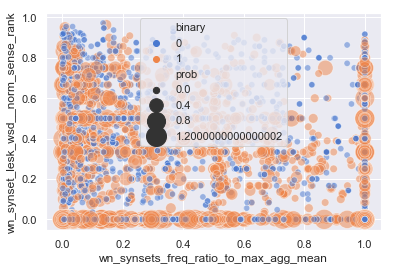

In [117]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

#Select wikipedia train set of concatenation
data = concat_features[0].train
#data = data.loc[data.cal_ngram_2_sim_min<0.3,]

complexity_plot = sns.scatterplot(x="wn_synsets_freq_ratio_to_max_agg_mean", y="wn_synset_lesk_wsd__norm_sense_rank", hue="binary", size='prob',
            sizes=(40, 400), alpha=.5, palette="muted",
            data=data)
plt.show(complexity_plot)

In [72]:
figure = complexity_plot.get_figure()
figure.savefig('../plots/features/syn-freq-to-avg-def-len.pdf')

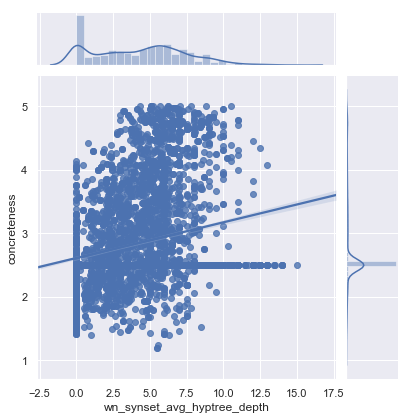

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

#Select wikipedia train set of concatenation
data = concat_features[0].train
#data = data.loc[data.cal_ngram_2_sim_min<0.3,]

complexity_plot = sns.jointplot(x="wn_synset_avg_hyptree_depth", y="concreteness", data=data, kind="reg")
plt.show(complexity_plot)

In [92]:
complexity_plot.savefig('../plots/features/wn-hyp-depth-to-conc.pdf')

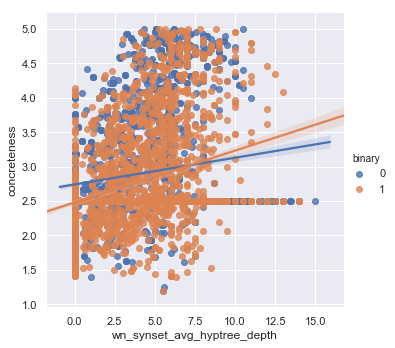

In [93]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

#Select wikipedia train set of concatenation
data = concat_features[0].train
#data = data.loc[data.cal_ngram_2_sim_min<0.3,]

complexity_plot = sns.lmplot(x="wn_synset_avg_hyptree_depth", y="concreteness", hue='binary', data=data)
plt.show(complexity_plot)

In [94]:
complexity_plot.savefig('../plots/features/wn-hyp-depth-to-conc-2.pdf')

Sense Rank example where covered in terms of copying piece of music is penalized compared to cover in terms of overlay

In [115]:
df.loc[df['target'] == 'covered',['target', 'sentence', 'wn_synset_lesk_wsd__norm_sense_rank']]

,target,sentence,wn_synset_lesk_wsd__norm_sense_rank
701,covered,"La India covered the song on her album , Sobre el Fuego as her third single from the album .",0.962963
4433,covered,"The skin is covered in chromatophores , which enable the squid to change color to suit its surroundings , making it practically invisible .",0.296296


# (3.6) Dictionary Features


In [15]:
import textatistic

academic_words = {}
with open("resources/dictionaries/academic_word_list.txt", encoding="utf8") as file:
    for line in file:
        word, rank = line.split()
        academic_words[word.strip()] = rank

prefixes = {}
with open("resources/dictionaries/prefixes.txt", encoding="utf8") as file:
    for line in file:
        prefix, definition, examples = line.split('\t')
        prefixes[prefix.replace('-', '').strip()] = definition

suffixes = {}
with open("resources/dictionaries/suffixes.txt", encoding="utf8") as file:
    for line in file:
        suffix, definition, examples = line.split('\t')
        suffixes[suffix.replace('-', '').strip()] = definition

with open("resources/dictionaries/biology_glossary.csv", encoding="utf8") as file:
    content = [line.strip().lower() for line in file.readlines()]
    gloss_biology = set(content)

with open("resources/dictionaries/geography_glossary.csv", encoding="utf8") as file:
    content = [line.strip().lower() for line in file.readlines()]
    gloss_geography = set(content)
    
with open("resources/dictionaries/physics_glossary.csv", encoding="utf8") as file:
    content = [line.strip().lower() for line in file.readlines()]
    gloss_physics = set(content)
    
with open("resources/dictionaries/stopwords_en.txt", encoding="utf8") as file:
    content = [line.strip().lower() for line in file.readlines()]
    stop_words = set(content)
    
with open("resources/dictionaries/most_freq_used_3000_words.txt", encoding="utf8") as file:
    content = [line.strip().lower() for line in file.readlines()]
    most_freq_used_3000_words = set(content)
    
with open("resources/dictionaries/most_freq_used_5000_words.txt", encoding="utf8") as file:
    content = [line.split()[1].strip().lower() for line in file.readlines()]
    most_freq_used_5000_words = set(content)

In [16]:
def features_dictionary(dataframe):
    df = dataframe.copy()
    df['dict_dale_chall'] = df.target.apply(lambda target : agg_feat_num_average(target, \
                            lambda target :  0 if textatistic.notdalechall_count(target) >= 1 else 1))
    df['dict_570_academic_words'] = df.target.apply(lambda target : agg_feat_num_max(target, \
                                                    lambda target : int(target in academic_words)))
    df['common_prefix'] = df.target.apply(lambda target : int(np.sum([1 for prefix in prefixes if target.startswith(prefix)]) > 0))
    df['common_suffix'] = df.target.apply(lambda target : int(np.sum([1 for suffix in suffixes if target.endswith(suffix)]) > 0))
    df['gloss_biology'] = df.target.apply(lambda target : int(target in gloss_biology))
    df['gloss_physics'] = df.target.apply(lambda target : int(target in gloss_physics))
    df['gloss_geography'] = df.target.apply(lambda target : int(target in gloss_geography))
    df['stop_word'] = df.target.apply(lambda target : int(target in stop_words))
    df['most_freq_used_3000_words'] = df.target.apply(lambda target : agg_feat_num_average(target, \
                                                    lambda target : int(target in most_freq_used_3000_words)))
    df['most_freq_used_5000_words'] = df.target.apply(lambda target : agg_feat_num_average(target, \
                                                    lambda target : int(target in most_freq_used_5000_words)))
    return df

fc_dictionary = FeatureCategory('corpus-based', features_dictionary)
feature_categories.append(fc_dictionary)

In [17]:
dataset_fc_dictionary = [FeatureDataset(ds.name, fc_dictionary, 
                fc_dictionary.func(ds.train), fc_dictionary.func(ds.test)) for ds in datasets]

In [19]:
train = dataset_fc_dictionary[0].train
train.loc[train.gloss_biology==1,]

,id,sentence,start,end,target,nat,non_nat,nat_marked,non_nat_marked,binary,...,dict_dale_chall,dict_570_academic_words,common_prefix,common_suffix,gloss_biology,gloss_physics,gloss_geography,stop_word,most_freq_used_3000_words,most_freq_used_5000_words
7,3XU9MCX6VODXPI3L8I02CM94TFB2R7,"Normally , the land will be passed down to fut...",91,100,community,10,10,0,0,0,...,0.0,1,1,1,1,0,1,0,1.0,1.0
169,3VJ4PFXFJ38EADQ6PROMNFFMC27AUQ,Axis is the nerve of the public space known as...,12,17,nerve,10,10,2,3,1,...,1.0,0,0,0,1,0,0,0,1.0,1.0
333,3INZSNUD80REOS5FBQKXHK0EKKUD94,Other attractions include the Al Ain Oasis in ...,147,151,heat,10,10,0,0,0,...,1.0,0,0,0,1,0,1,0,1.0,1.0
524,3XD2A6FGFNVKQHOX8GFMCJMELN4S9D,In certain organometallic compounds such as fe...,100,107,organic,10,10,0,0,0,...,0.0,0,0,1,1,0,1,0,1.0,1.0
558,3XD2A6FGFNVKQHOX8GFMCJMELN4S9D,The term `` metalorganics '' usually refers to...,126,133,organic,10,10,0,0,0,...,0.0,0,0,1,1,0,1,0,1.0,1.0
561,3XD2A6FGFNVKQHOX8GFMCJMELN4S9D,The organic ligands often bind the metal throu...,4,11,organic,10,10,0,0,0,...,0.0,0,0,1,1,0,1,0,1.0,1.0
603,3KLL7H3EGD2TXFNK0N8J0N49346HVX,"Schistosomiasis , caused by one genus of trema...",32,37,genus,10,10,4,3,1,...,0.0,0,0,0,1,0,1,0,0.0,0.0
617,3KLL7H3EGD2TXFNK0N8J0N49346HVX,Over half of all known flatworm species are pa...,32,39,species,10,10,1,1,1,...,0.0,0,0,0,1,0,1,0,1.0,1.0
837,3W31J70BASXO0WISFRGBNNWCAEUKC5,The 1900 Universal Exhibition in Paris spread ...,59,64,style,10,10,0,0,0,...,0.0,1,0,0,1,0,0,0,1.0,1.0
863,3EAWOID6MTYIMFHO2F1YUV5SHN4V09,The roof of the Mudéjar style church features ...,24,29,style,10,10,0,0,0,...,0.0,1,0,0,1,0,0,0,1.0,1.0


In [170]:
concat_features = concat_feature_datasets(dataset_fc_semantic, dataset_fc_orthographic,
                dataset_fc_psycholinguistic, dataset_fc_corpus_based, dataset_fc_dictionary)

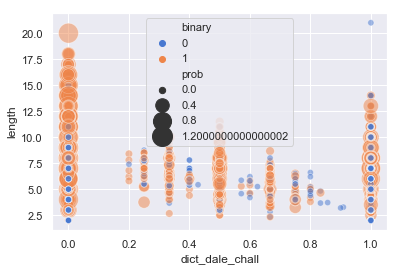

In [171]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

#Select wikipedia train set of concatenation
data = concat_features[2].train
#data = data.loc[data.cal_ngram_2_sim_min<0.3,]

complexity_plot = sns.scatterplot(x="dict_dale_chall", y="length", hue="binary", size='prob',
            sizes=(40, 400), alpha=.5, palette="muted",
            data=data)
plt.show(complexity_plot)

In [172]:
complexity_plot_figure = complexity_plot.get_figure()
complexity_plot_figure.savefig('../plots/features/len-to-dale-chall.pdf')

# Feature Importance
Here we compute individual feature importance based on different metrics. For example, we implement and compute the F-Score, providing an idea of the discrimination power the feature has.

In [14]:
from collections import namedtuple
Result = namedtuple('Result', 'dataset, fc, measure')
Dataset = namedtuple('Dataset', 'name, train, test')
FeatureDataset = namedtuple('FeatureDataset', 'dataset_name, fc, train, test')
FeatureCategory = namedtuple('FeatureCategory', 'name, func')

In [25]:
def remove_labels_from_df(dataframe):
    df = dataframe.copy()
    df = df.drop(['id', 'sentence', 'target', 'nat', 'non_nat', 
                   'nat_marked', 'non_nat_marked', 'prob', 'start', 'end'], axis = 1)
    return df
    
def transform_feat_to_num(dataframe):
    pass

In [ ]:
def feat_importance_f_score(dataframe, feat_name, label_name):
    df = dataframe.copy()
    mean_feat = np.mean(df.loc[:, [feat_name]])[0]
    means = df.loc[: , [feat_name, label_name]].groupby(label_name).mean().reset_index()
    mean_negativ = means.loc[means[label_name] == 0, [feat_name]][feat_name][0]
    mean_positiv = means.loc[means[label_name] == 1, [feat_name]][feat_name][1]
    # Compute the sum of deviations of the class mean from the overall mean
    class_mean_devs = (mean_positiv - mean_feat)**2 + (mean_negativ - mean_feat)**2
    # Compute neagtive instance based values
    neg_inst = df.loc[df[label_name] == 0, [feat_name]]
    std_dev_neg = (np.sum((neg_inst - mean_negativ)**2) / (len(neg_inst) - 1))[feat_name]
    #Compute positive instance based values
    pos_inst = df.loc[df[label_name] == 1, [feat_name]]
    std_dev_pos = (np.sum((pos_inst - mean_positiv)**2) / (len(pos_inst) - 1))[feat_name]
    return class_mean_devs / (std_dev_neg + std_dev_pos)

def compute_all_feat_importance_metrics(dataframe, label_name):
    pass
    

df_feat = df.drop(['id', 'sentence', 'target', 'nat', 'non_nat', 
                   'nat_marked', 'non_nat_marked', 'prob'], axis = 1)
print(df_feat.mean())
print(df_feat.groupby('binary').mean())

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn import model_selection
from sklearn.neural_network import MLPClassifier


def average_classification_f1(train, test):
    print('average_classification')
    x_train = train.loc[:, train.columns != 'binary']
    y_train = train.binary.values
    x_test = test.loc[:, test.columns != 'binary']
    y_test = test.binary.values
    seed = 7
    #knn = MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto',
     #  beta_1=0.9, beta_2=0.999, early_stopping=False,
    #   epsilon=1e-08, hidden_layer_sizes=(5, 100), learning_rate='constant',
    #   learning_rate_init=0.001, max_iter=200, momentum=0.9,
    #   nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
    #   solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
    #   warm_start=False)
    knn = svm.SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
        decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
        max_iter=-1, probability=False, random_state=None, shrinking=True,
        tol=0.001, verbose=False)
    knn.fit(x_train, y_train) 
    #prediction = knn.predict(x_test)
    #f1score = f1_score(y_test, prediction)
    kfold = model_selection.KFold(n_splits=2, random_state=seed)
    cv_results = model_selection.cross_val_score(knn, x_train, y_train, cv=kfold, scoring=make_scorer(f1_score))
    return cv_results

In [18]:
datasets = dataset_fc_orthographic

In [26]:
results = [Result(fs.dataset_name, fs.fc, 
    average_classification_f1(remove_labels_from_df(fs.train), 
        remove_labels_from_df(fs.test))) for fs in datasets]

average_classification
average_classification
average_classification


In [27]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

feature_eval_data = [{'dataset' : result.dataset, 
                    'fc' : result.fc.name, 'f1-score' : result.measure[0]} 
                   for result in results]
feature_eval_data = pd.DataFrame.from_records(feature_eval_data)

#dim_plot = sns.lineplot(x="dimension", y="f1-score",
#             hue="dataset", style="dataset", err_style = 'band',
#             data=dimensions_data)
#print(dimensions_data)
#plt.show(dim_plot)
feature_eval_data

,dataset,f1-score,fc
0,Wikipedia,0.704065,orthographic
1,WikiNews,0.700285,orthographic
2,News,0.639290,orthographic


# Misc

In [ ]:
pd.options.display.max_colwidth = 200
df_trans = df.loc[df.length < 5, ["sentence", "target", "binary"]]
df_trans.loc[df_trans.binary == 1]

In [ ]:
group = df.loc[:,['target', 'binary']].groupby(['target'], as_index=False)
grouped = group.filter(lambda x : (x['binary'].mean() > 0) & (x['binary'].mean() < 1))
targets = grouped['target'].unique()
targets

In [ ]:
df.loc[df['target'] == 'major',['target', 'binary', 'id','sentence', 'ctx_length']]

In [ ]:
import requests
from lxml import html

page = requests.get('http://sentence.yourdictionary.com/decomposition')
tree = html.fromstring(page.content)
sentences = tree.xpath("//div[@class='li_content']/text()")

for sentence in sentences:
    print(sentence)

In [1]:
import requests
from lxml import html

page = requests.get('https://prowritingaid.com/en/Collocation/Dictionary?word=Coffee')
tree = html.fromstring(page.content)
sentences = tree.xpath("//a[@class='pwa-link']/text()")

for sentence in sentences:
    print(sentence)

table
cup
shop
mug
down
look
hand
two
back
like
machine
pot
front
sat
tea
get
make
took
down
over
pot
black
like
want
two
hot
will
made
back
went
table
cup
down
shop
get
took
over
pot
two
like
make
back
mug
will
look
black
made
hot
can
went
want
hand
room
sugar
put
morning
just
sat
front
after
cup
tea
table
pot
sugar
shop
house
cups
cocoa
houses
mug
cotton
morning
room
milk
cup
tea
sugar
shop
house
table
cocoa
pot
mug
tobacco
cotton
bread
room
plantation
juice
chocolate
morning
banana
milk
alcohol
fruit
bean
break
hand
breakfast
bacon
rubber
restaurant
rice
sandwich
be
sip
drink
have
make
take
will
bring
'll
set
order
's
sit
serve
get
want
pour
finish
can
brew
steam
go
come
put
offer
use
buy
meet
carry
do
much
empty
black
hot
second
More
such
first
long
strong
own
many
instant
half
good
low
third
fresh
local
endless
little
fourth
cold
hard
high
nice
decent
large
public
well
then
not
when
just
down
Just
only
together
much
too
now
very
daily
where
instead
there
late
back
away
maybe
here


In [ ]:
df.loc[df['sentence'].str.contains('although'),['target', 'sentence', 'binary']]

In [ ]:
df['ctx_length'] = df.sentence.apply(lambda sent : np.mean([len(t) for t in sent.split()]))
df['ctx_target_length_dev'] = df.length - df.ctx_length
df.loc[:,['target', 'length', 'ctx_length', 'ctx_target_length_dev', 'binary','sentence']]
grouped = df.loc[:,['sentence', 'binary', 'ctx_length']].groupby('sentence').agg(['sum']).eval('Col4 = Col2 / Col3')
grouped

In [ ]:
df.loc[(df['ctx_target_length_dev'] > 2) & (df['binary'] == 0),['id','target', 'sentence', 'binary', 'ctx_target_length_dev']]

In [ ]:
wordNetLemmatizer = WordNetLemmatizer()
print(wordNetLemmatizer.lemmatize("written", 'v'))

In [ ]:
from whoosh.index import create_in
from whoosh.fields import *
schema = Schema(title=TEXT(stored=True), path=ID(stored=True), content=TEXT)
ix = create_in("indexdir", schema)
writer = ix.writer()
writer.add_document(title=u"First document", path=u"/a", \
                    content=u"This is the first document we've added!")
writer.add_document(title=u"Second document", path=u"/b",\
                     content=u"The second one is even more interesting!")
writer.commit()
from whoosh.qparser import QueryParser
with ix.searcher() as searcher:
    query = QueryParser("content", ix.schema).parse("first")
    results = searcher.search(query)
    results[0]
        
{"title": u"First document", "path": u"/a"}